In [375]:
from pylab import *

import csv
import numpy as np
import utils
import hrr_utils
import time
import scipy
import random

from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline 

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [376]:
reload(hrr_utils)

<module 'hrr_utils' from 'hrr_utils.pyc'>

In [377]:
N=10000

def genX(verbs, indices):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))
    
    for m in range(len(indices)):
        pair = verbs[indices[m]]
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2


def closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present,rcond=5e-2), Past)

def loss(W, X_train, y_train, lnum=1):
    lost = norm(np.dot(X_train,W) - y_train, lnum)
    return lost

def train(X_train, y_train, reg=0):
    ''' Build a model from X_train -> y_train '''
    xtx = X_train.T.dot(X_train)
    return scipy.linalg.solve(xtx + reg*np.eye(xtx.shape[0]), X_train.T.dot(y_train), sym_pos=True)

# no regularization yet
def train_gd(X_train, y_train, model, alpha=0.1, reg=0):
    ''' Build a model from X_train -> y_train using batch gradient descent 
        Gradient update equation: W = W.T(X.TX) - y.TX + 2alphaW.T
    '''
    
    gradient = 2*np.dot(model.T, np.dot(X_train.T,X_train))
    gradient -= 2*np.dot(y_train.T,X_train)
    gradient += 2*reg*model.T
    gradient = gradient.T/X_train.shape[0]
    model = model - alpha * gradient
    return model

def train_sgd(X_train, y_train, model, i, alpha=0.1, reg=0):
    ''' Build a model from X_train -> y_train using stochastic gradient descent 
        Gradient update equation: W = W.T(X[i].TX[i]) - y[i].TX[i] + 2alphaW.T
    '''
    #i = int(np.random.uniform(low=0,high=X_train.shape[0]))
    gradient = 2*np.dot(model.T, np.outer(X_train[i,:].T, X_train[i,:]))
    gradient -= 2*np.outer(y_train[i,:].T, X_train[i,:].T)
    gradient += 2*reg*model.T
    gradient = gradient.T/X_train.shape[0]
    model += model - alpha * gradient
    
    return model

def predict(model, X):
    ''' From model and data points, output prediction vectors '''
    return X.dot(model)

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def round_to_tick(number):
    """Round a number to the closest half integer."""
    return round(number * 2) / 2

def graph(x, y1, y2, y1std, y2std, title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   
    fig = plt.figure(figsize=(4,3))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xticks(np.arange(0, 1701, 400))
    
    start = round_to_tick(min(min(y1), min(y2)) - max(max(y1std),max(y2std)))
    end = round_to_tick(max(max(y1), max(y2)) + max(max(y1std),max(y2std)))
    
    plt.yticks(np.arange(start-.5, end+.5, .5))
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
    plt.title(title,fontsize=16)

    plt.xlim([0, 1700])

    plt.tight_layout()
# https://matplotlib.org/api/lines_api.html
def graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   

    fig = plt.figure(figsize=(4,3))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xticks(np.arange(0, 1701, 400))
    start = round_to_tick(min(min(y1), min(y2)) - max(max(y1std),max(y2std)))
    end = round_to_tick(max(max(y1), max(y2)) + max(max(y1std),max(y2std)))
    
    plt.yticks(np.arange(start-.5, end+.5, .5))
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')
    plt.plot(x, y1irregular, ':', c='b', lw=2, label='Train')
    plt.plot(x, y2irregular, ':', c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
    plt.title(title,fontsize=16)

    plt.xlim([0, 1700])

    plt.tight_layout()

In [378]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)


regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

train_frac = 2/3.0

irregular_train_idx = int(train_frac*len(irreg_pres))
train_irreg = irregular[0:irregular_train_idx]

regular_train_idx = 1700 - len(train_irreg) 
train_reg = regular[0:regular_train_idx]

test_reg = regular[regular_train_idx:]
test_irreg = irregular[irregular_train_idx:]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

train_all = train_reg + train_irreg
test_all = test_reg + test_irreg

train_all_indices = [i for i in range(len(train_all))]
test_all_indices = [i for i in range(len(test_all))]
random.shuffle(train_all_indices)
random.shuffle(test_all_indices)

In [379]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_all,train_all_indices)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_all, test_all_indices)

In [380]:
from sklearn.decomposition import PCA, FastICA, TruncatedSVD, NMF


In [381]:
train_all[train_all_indices[0]]

('translate', 'translated', 15)

In [382]:
mean_train = trainpres1.mean()

In [383]:
trainstack = np.hstack((trainpres1, trainpast1))

In [384]:
ncomponents = 300
#pca_encoder = TruncatedSVD(ncomponents)
pca_encoder = PCA(ncomponents)
fica_encoder = FastICA(ncomponents)



In [385]:
tstart = time.time()
pca_encoder.fit(trainpres1)
print 'Duration: ', time.time() - tstart


Duration:  20.6203479767


In [386]:
pc_comp = pca_encoder.components_
scores = pca_encoder.transform(trainpres1)

In [387]:
pc_comp.shape

(300, 10000)

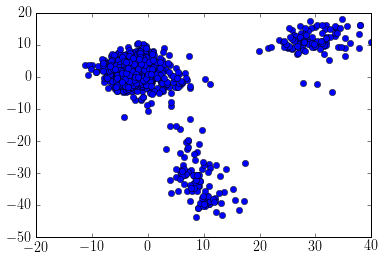

In [388]:
plt.plot(scores[:,2], scores[:,1], 'o')

In [389]:
past_scores = pca_encoder.transform(trainpast1)

In [390]:
past_scores.shape

(1700, 300)

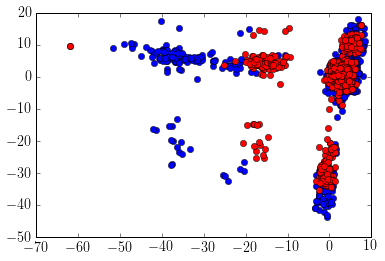

In [391]:
plt.plot(scores[:,0], scores[:,1], 'bo')
plt.plot(past_scores[:,0], past_scores[:,1], 'ro')


In [392]:
tstart = time.time()
which_pcs = np.arange(300)
fica_encoder.fit(scores[:,which_pcs])
print 'Duration: ', time.time() - tstart


Duration:  14.5605211258


In [393]:
ic_comp = fica_encoder.components_
ic_comp.shape

(300, 300)

In [394]:
ic_scores = fica_encoder.transform(scores[:, which_pcs])
ic_past_scores = fica_encoder.transform(past_scores[:, which_pcs])

(300, 300)


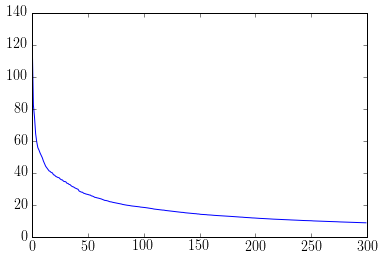

In [395]:
ll2 = pca_encoder.explained_variance_
plot(ll2)
SS = np.diag(ll2)
print SS.shape

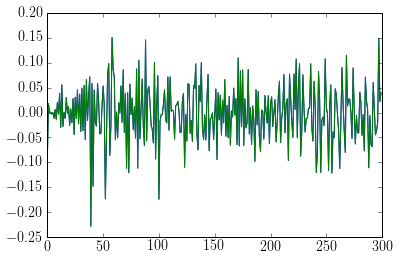

In [396]:
icpc_recon = np.dot(ic_scores, ic_comp)
norm_scores = scores[0,which_pcs] / ll2
plot(norm_scores/np.linalg.norm(norm_scores))
plot(icpc_recon[0, :]/np.linalg.norm(icpc_recon[0,:]))

In [397]:
pcic_comp = np.dot(ic_comp, pc_comp[which_pcs, :])
pcicW_comp = np.dot(ic_comp, np.dot(SS, pc_comp))
print pcic_comp.shape, pcicW_comp.shape

(300, 10000) (300, 10000)


In [398]:
ic_comp.shape

(300, 300)

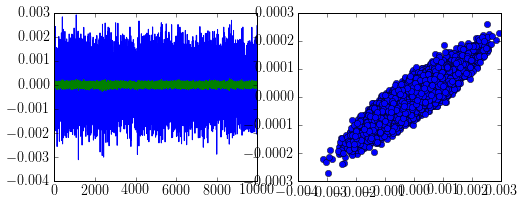

In [399]:
figure(figsize=(8,3))
subplot(121)
plt.plot(pcicW_comp[0,:])
plt.plot(pcic_comp[0,:])
subplot(122)
plt.plot(pcicW_comp[0, :], pcic_comp[0,:], 'o')


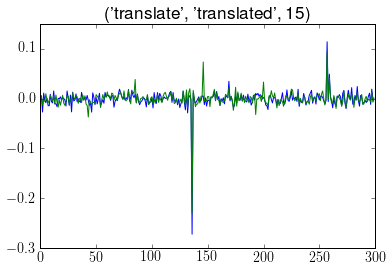

In [400]:
widx=0
plot(ic_scores[widx,:])
plot(ic_past_scores[widx,:])
title(train_all[train_all_indices[widx]])

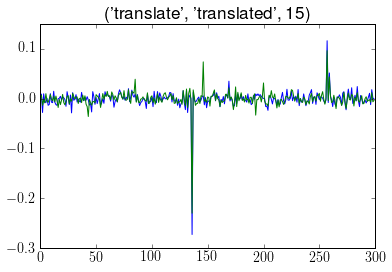

In [401]:
encode_ic_score = np.dot(trainpres1[widx,:], pcic_comp.T)
enc_ic_past_score = np.dot(trainpast1[widx, :], pcic_comp.T)

plot(encode_ic_score)
plot(enc_ic_past_score)
title(train_all[train_all_indices[widx]])

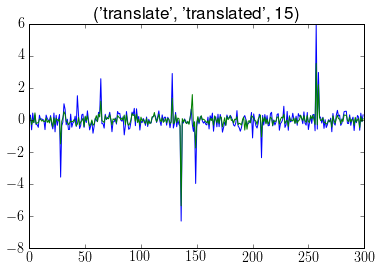

In [402]:
encode_icW_score = np.dot(trainpres1[widx,:], pcicW_comp.T)
enc_icW_past_score = np.dot(trainpast1[widx, :], pcicW_comp.T)

plot(encode_icW_score)
plot(enc_icW_past_score)
title(train_all[train_all_indices[widx]])

In the ICA space, the primary difference between the whitened and non-whitened representations is that certain dimensions are slightly rescaled. Looking at above the blue spike on the right in the top plot is reduced compared to the bottom. This spike looks like the trigram 'ing' from the resonance decoder. Since 'ing' is a very common trigram it is reduced due to the whitening.

The two downward pointing spikes on the left decode as '#break..' in the resonance attractor, with the '#bre' very strong, and a bit from 'a'. 

In [403]:
#argmax(encode_ic_score[200:])
argmax(-enc_ic_past_score)

136

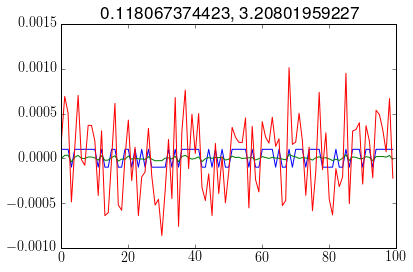

In [404]:
ic_recon = np.dot(ic_scores[widx, :], pcic_comp)
icW_recon = np.dot(ic_scores[widx, :], pcicW_comp)

plot(trainpres1[widx, :100] / N)
plot(ic_recon[:100])
plot(icW_recon[:100])

title(str(np.dot(trainpres1[widx, :], ic_recon)) +", "+ str(np.dot(trainpres1[widx, :], icW_recon)))

(0, 100)

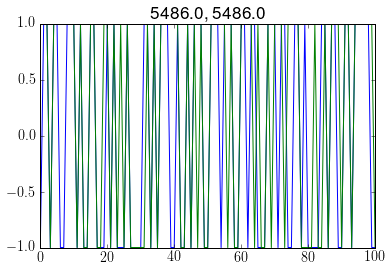

In [407]:
mxidx = np.argmax(-ic_scores[widx,:])
ic_recon = np.dot(ic_scores[widx, :], pcic_comp)
ic_renorm = 2*(ic_recon > 0)-1
icW_recon = np.dot(ic_scores[widx, :], pcicW_comp)
icW_renorm = 2*(ic_recon > 0)-1

plot(ic_renorm)
plot(trainpres1[widx])

title(str(np.dot(ic_renorm, trainpres1[widx])) + ", " + str(np.dot(icW_renorm, trainpres1[widx])))
xlim(0, 100)

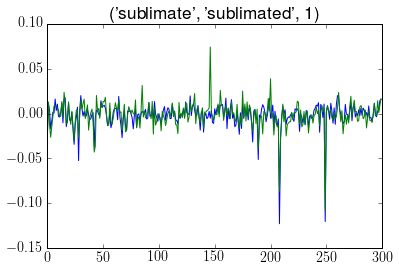

In [408]:
tidx=1
ic_testpres_scores = np.dot(testpres1[tidx, :], pcic_comp.T)
ic_testpast_scores = np.dot(testpast1[tidx, :], pcic_comp.T)
plot(ic_testpres_scores)
plot(ic_testpast_scores)
title(test_all[test_all_indices[tidx]])

# Does this even make sense?

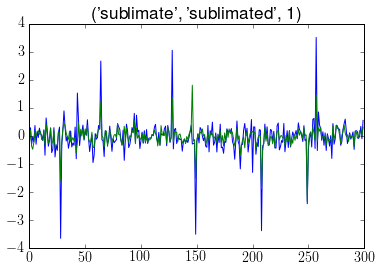

In [409]:
tidx=1
ic_testpres_scores = np.dot(testpres1[tidx, :], pcicW_comp.T)
ic_testpast_scores = np.dot(testpast1[tidx, :], pcicW_comp.T)
plot(ic_testpres_scores)
plot(ic_testpast_scores)
title(test_all[test_all_indices[tidx]])

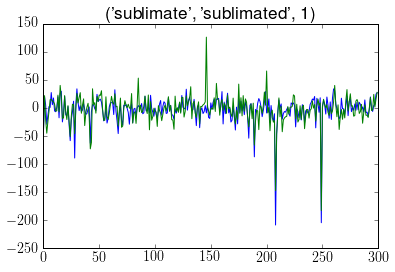

In [410]:
tidx=1
ic_testpres_scores = np.dot(testpres1[tidx, :], pinv(pcicW_comp))
ic_testpast_scores = np.dot(testpast1[tidx, :], pinv(pcicW_comp))
plot(ic_testpres_scores)
plot(ic_testpast_scores)
title(test_all[test_all_indices[tidx]])

## Learning in PCA/ICA space

Ok, so now going to use the representations in the sparse-whitened space as the basis of the words, and then attach present to past tense and do the learning.



In [411]:
letter_vecs1 = np.zeros((len(alphabet), N))
letter_vecs2 = np.zeros((len(alphabet), N))

for ia, al in enumerate(alphabet):
    letter_vecs1[ia, :] = dic1[al]
    letter_vecs2[ia, :] = dic2[al]
    

In [412]:
ic_vecs1 = 2*(np.random.randn(len(which_pcs), N) < 0) - 1
ic_vecs2 = 2*(np.random.randn(len(which_pcs), N) < 0) - 1


In [413]:
trpres1 = np.dot(np.dot(trainpres1, pcic_comp.T), ic_vecs1)
trpast1 = np.dot(np.dot(trainpast1, pcic_comp.T), ic_vecs2)
ttpres1 = np.dot(np.dot(testpres1, pcic_comp.T), ic_vecs1)
ttpast1 = np.dot(np.dot(testpast1, pcic_comp.T), ic_vecs2)


In [424]:
trpres1[trpres1>0] = 1
trpres1[trpres1<0] = -1
trpast1[trpast1>0] = 1
trpast1[trpast1<0] = -1
ttpres1[ttpres1>0] = 1
ttpres1[ttpres1<0] = -1
ttpast1[ttpast1>0] = 1
ttpast1[ttpast1<0] = -1

In [434]:
bv = trpres1[0,:] * trpast1[0,:]
bv += trpres1[1,:] * trpast1[1,:]
np.dot(trpast1[0,:], bv*trpres1[0,:])

10022.0

In [462]:
mem_vector = np.zeros(N)

check_steps = 10
check_x = np.arange(10, trainpres1.shape[0], check_steps)
check_c = 0
train_sim_mean = np.zeros(len(check_x))
train_sim_std = np.zeros(len(check_x))
test_sim_mean = np.zeros(len(check_x))
test_sim_std = np.zeros(len(check_x))


for widx in range(trainpres1.shape[0]):
    tpres1c = trpres1[widx, :]
    tpast1c = trpast1[widx, :]
    
    mem_vector += tpres1c * tpast1c
    
    
    if widx in check_x:
        print widx,
        tpres1c_in = trpres1[:widx, :]
        tpast1c_out = tpres1c_in * mem_vector
        
        train_sims = np.sum(trpast1[:widx, :] * tpast1c_out, axis=1)
        
        train_sim_mean[check_c] = train_sims.mean()
        train_sim_std[check_c] = train_sims.std()
        
        ttpast1c_out = ttpres1 * mem_vector
        test_sims = np.sum(ttpast1 * ttpast1c_out, axis=1)
        
        test_sim_mean[check_c] = test_sims.mean()
        test_sim_std[check_c] = test_sims.std()
        
        check_c+=1


 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690


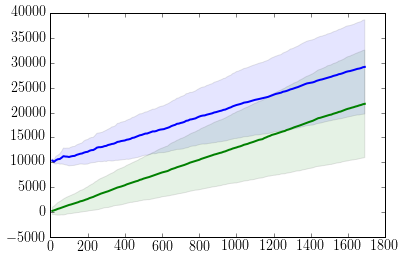

In [464]:
plot(check_x, train_sim_mean, c='b', lw=2)
fill_between(check_x, train_sim_mean-train_sim_std, train_sim_mean+train_sim_std, 
             facecolor='b', alpha=0.1)

plot(check_x, test_sim_mean, c='g', lw=2)
fill_between(check_x, test_sim_mean-test_sim_std, test_sim_mean+test_sim_std, 
             facecolor='g', alpha=0.1)



In [468]:
mem_vector = np.zeros(N)

check_x = np.arange(10, trainpres1.shape[0], check_steps)
check_c = 0
train_sim_mean = np.zeros(len(check_x))
train_sim_std = np.zeros(len(check_x))
test_sim_mean = np.zeros(len(check_x))
test_sim_std = np.zeros(len(check_x))

dd = N

for widx in range(trainpres1.shape[0]):
    tpres1c = trainpres1[widx, :]
    tpast1c = trainpast2[widx, :]
    
    tpast1_pred = tpres1c * mem_vector
    pred_sim = np.dot(tpast1_pred, tpast1c)
    
    
    mem_vector += (dd - pred_sim)/dd * tpres1c * tpast1c
    
    
    if widx in check_x:
        print widx,
        tpres1c_in = trainpres1[:widx, :]
        tpast1c_out = tpres1c_in * mem_vector
        
        train_sims = np.sum(trainpast2[:widx, :] * tpast1c_out, axis=1)
        
        train_sim_mean[check_c] = train_sims.mean()
        train_sim_std[check_c] = train_sims.std()
        
        ttpast1c_out = testpres1 * mem_vector
        test_sims = np.sum(testpast2 * ttpast1c_out, axis=1)
        
        test_sim_mean[check_c] = test_sims.mean()
        test_sim_std[check_c] = test_sims.std()
        
        check_c+=1


 10 30 50 70 90 110 130 150 170 190 210 230 250 270 290 310 330 350 370 390 410 430 450 470 490 510 530 550 570 590 610 630 650 670 690 710 730 750 770 790 810 830 850 870 890 910 930 950 970 990 1010 1030 1050 1070 1090 1110 1130 1150 1170 1190 1210 1230 1250 1270 1290 1310 1330 1350 1370 1390 1410 1430 1450 1470 1490 1510 1530 1550 1570 1590 1610 1630 1650 1670 1690


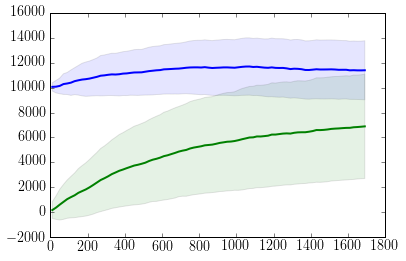

In [469]:
plot(check_x, train_sim_mean, c='b', lw=2)
fill_between(check_x, train_sim_mean-train_sim_std, train_sim_mean+train_sim_std, 
             facecolor='b', alpha=0.1)

plot(check_x, test_sim_mean, c='g', lw=2)
fill_between(check_x, test_sim_mean-test_sim_std, test_sim_mean+test_sim_std, 
             facecolor='g', alpha=0.1)


In [465]:
mem_vector = np.zeros(N)

check_x = np.arange(10, trainpres1.shape[0], check_steps)
check_c = 0
train_sim_mean = np.zeros(len(check_x))
train_sim_std = np.zeros(len(check_x))
test_sim_mean = np.zeros(len(check_x))
test_sim_std = np.zeros(len(check_x))

dd = N

for widx in range(trainpres1.shape[0]):
    tpres1c = trpres1[widx, :]
    tpast1c = trpast1[widx, :]
    
    tpast1_pred = tpres1c * mem_vector
    pred_sim = np.dot(tpast1_pred, tpast1c)
    
    
    mem_vector += (dd - pred_sim)/dd * tpres1c * tpast1c
    
    
    if widx in check_x:
        print widx,
        tpres1c_in = trpres1[:widx, :]
        tpast1c_out = tpres1c_in * mem_vector
        
        train_sims = np.sum(trpast1[:widx, :] * tpast1c_out, axis=1)
        
        train_sim_mean[check_c] = train_sims.mean()
        train_sim_std[check_c] = train_sims.std()
        
        ttpast1c_out = ttpres1 * mem_vector
        test_sims = np.sum(ttpast1 * ttpast1c_out, axis=1)
        
        test_sim_mean[check_c] = test_sims.mean()
        test_sim_std[check_c] = test_sims.std()
        
        check_c+=1


10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890 900 910 920 930 940 950 960 970 980 990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 1610 1620 1630 1640 1650 1660 1670 1680 1690


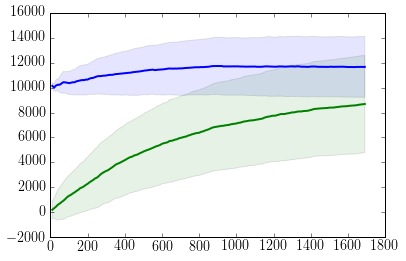

In [466]:
plot(check_x, train_sim_mean, c='b', lw=2)
fill_between(check_x, train_sim_mean-train_sim_std, train_sim_mean+train_sim_std, 
             facecolor='b', alpha=0.1)

plot(check_x, test_sim_mean, c='g', lw=2)
fill_between(check_x, test_sim_mean-test_sim_std, test_sim_mean+test_sim_std, 
             facecolor='g', alpha=0.1)


In [467]:
mem_matrix = np.zeros((N,N))

check_steps = 20
check_x = np.arange(10, trainpres1.shape[0], check_steps)
check_c = 0
train_sim_mean = np.zeros(len(check_x))
train_sim_std = np.zeros(len(check_x))
test_sim_mean = np.zeros(len(check_x))
test_sim_std = np.zeros(len(check_x))


for widx in range(trainpres1.shape[0]):
    tpres1c = trpres1[widx, :]
    tpast1c = trpast1[widx, :]
    
    mem_matrix += np.outer(tpres1c.T,  tpast1c)
    
    
    if widx in check_x:
        print widx,
        tpres1c_in = trpres1[:widx, :]
        tpast1c_out = tpres1c_in.dot(mem_matrix)
        
        train_sims = np.sum(trpast1[:widx, :] * tpast1c_out, axis=1)
        
        train_sim_mean[check_c] = train_sims.mean()
        train_sim_std[check_c] = train_sims.std()
        
        ttpast1c_out = ttpres1.dot(mem_matrix)
        test_sims = np.sum(ttpast1* ttpast1c_out, axis=1)
        
        test_sim_mean[check_c] = test_sims.mean()
        test_sim_std[check_c] = test_sims.std()
        
        check_c+=1


10 30 50 70 90 110 130 150 170 190 210 230 250 270

KeyboardInterrupt: 

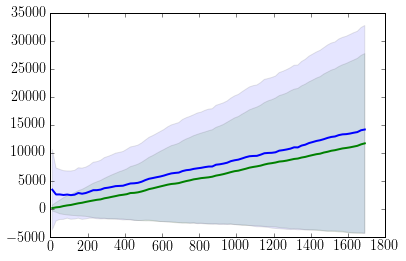

In [347]:
plot(check_x, train_sim_mean, c='b', lw=2)
fill_between(check_x, train_sim_mean-train_sim_std, train_sim_mean+train_sim_std, 
             facecolor='b', alpha=0.1)

plot(check_x, test_sim_mean, c='g', lw=2)
fill_between(check_x, test_sim_mean-test_sim_std, test_sim_mean+test_sim_std, 
             facecolor='g', alpha=0.1)


In [370]:
pred_sim

36.651470618135342

In [312]:
widx=5
tpres1c_in = np.dot(np.dot(trainpres1[:widx, :], pcic_comp.T), ic_vecs1)

In [319]:
mem_vector = 2*(np.random.randn(N)>0)-1


tpres1c_in - tpres1c_in*mem_vector


array([[ 1.03719596,  0.        ,  0.90284327, ...,  0.54492956,
         0.        , -1.94808934],
       [-0.17941432,  0.        , -0.30378813, ..., -0.81549314,
         0.        , -1.30526915],
       [-0.79436277,  0.        , -1.13657064, ..., -0.01011924,
         0.        ,  1.43199801],
       [ 1.0428245 ,  0.        ,  0.78620922, ...,  1.09401443,
         0.        , -0.43893   ],
       [ 0.42571172,  0.        , -0.57661568, ..., -0.80155896,
         0.        ,  0.40164109]])

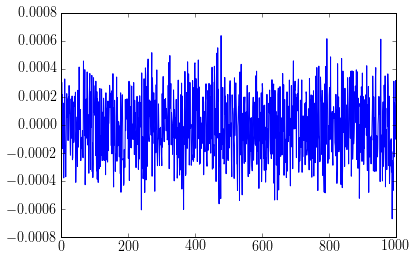

In [211]:
plot(w_recon)

In [212]:
letter_vecs=np.array(dic1.values())

In [213]:
import string
alphabet = string.ascii_lowercase+"."+"#"
D = len(alphabet)

In [307]:
#letter_vecs = np.array(dic1.values())
#letter_vecs = 2 * (np.random.randn(D, N) < 0) - 1


#ngram_str = 'powers'
#bound_vec = ngram_encode(ngram_str, letter_vecs, alph)
#bound_vec = ngram_encode_cl(ngram_str, letter_vecs, alph)
bound_vec = pcic_comp[22, :]
#bound_vec = trainpres1[widx] #ic_renorm #np.dot(ic_scores[widx, :], pcic_comp)


# initializing the states as random works just as well as the intention, which
# is to initialize as the superposition of all D states.
l0_state = np.random.randn(N)
l1_state = np.random.randn(N)
l2_state = np.random.randn(N)
l3_state = np.random.randn(N)
l4_state = np.random.randn(N)
l5_state = np.random.randn(N)
l6_state = np.random.randn(N)
l7_state = np.random.randn(N)

l1_state = np.dot(letter_vecs.T, np.dot(l1_state, letter_vecs.T))
l2_state = np.dot(letter_vecs.T, np.dot(l2_state, letter_vecs.T))
l3_state = np.dot(letter_vecs.T, np.dot(l3_state, letter_vecs.T))
l4_state = np.dot(letter_vecs.T, np.dot(l4_state, letter_vecs.T))
l5_state = np.dot(letter_vecs.T, np.dot(l5_state, letter_vecs.T))
l6_state = np.dot(letter_vecs.T, np.dot(l6_state, letter_vecs.T))
l7_state = np.dot(letter_vecs.T, np.dot(l7_state, letter_vecs.T))

# the clipping non-linearity will lead to arbitrary norms, so need to keep vector normalized
l1_state = l1_state/norm(l1_state)
l2_state = l2_state/norm(l2_state)
l3_state = l3_state/norm(l3_state)
l4_state = l4_state/norm(l4_state)
l5_state = l5_state/norm(l5_state)
l6_state = l6_state/norm(l6_state)
l7_state = l7_state/norm(l7_state)

# we know the first letter
l0_state = letter_vecs[alphabet.find('#'), :]


n_steps = 500

l1_coef_hist = np.zeros((n_steps, D))
l2_coef_hist = np.zeros((n_steps, D))
l3_coef_hist = np.zeros((n_steps, D))
l4_coef_hist = np.zeros((n_steps, D))
l5_coef_hist = np.zeros((n_steps, D))
l6_coef_hist = np.zeros((n_steps, D))
l7_coef_hist = np.zeros((n_steps, D))

In [308]:
tst = time.time()
for i in range(n_steps):
    l1_coef_hist[i, :] = np.dot(letter_vecs, l1_state)
    l2_coef_hist[i, :] = np.dot(letter_vecs, l2_state)
    l3_coef_hist[i, :] = np.dot(letter_vecs, l3_state)
    l4_coef_hist[i, :] = np.dot(letter_vecs, l4_state)
    l5_coef_hist[i, :] = np.dot(letter_vecs, l5_state)
    l6_coef_hist[i, :] = np.dot(letter_vecs, l6_state)
    l7_coef_hist[i, :] = np.dot(letter_vecs, l7_state)

    ## Need to make sure that the largest absolute value is always positive,
    ## because the unbinding inference can flip 2 and be the same
    
    mx1idx = np.argmax(np.abs(l1_coef_hist[i,:]))
    l1_state = l1_state * np.sign(l1_coef_hist[i, mx1idx])
    #l1_coef_hist[i, :] *= np.sign(l1_coef_hist[i, mx1idx])
    
    mx2idx = np.argmax(np.abs(l2_coef_hist[i,:]))
    l2_state = l2_state *  np.sign(l2_coef_hist[i, mx2idx])
    #l2_coef_hist[i, :] *= np.sign(l2_coef_hist[i, mx1idx])
    
    mx3idx = np.argmax(np.abs(l3_coef_hist[i,:]))
    l3_state = l3_state * np.sign(l3_coef_hist[i, mx3idx])
    #l3_coef_hist[i, :] *= np.sign(l3_coef_hist[i, mx1idx])
    
    mx4idx = np.argmax(np.abs(l4_coef_hist[i,:]))
    l4_state = l4_state * np.sign(l4_coef_hist[i, mx4idx])
    #l4_coef_hist[i, :] *= np.sign(l4_coef_hist[i, mx1idx])
    
    mx5idx = np.argmax(np.abs(l5_coef_hist[i,:]))
    l5_state = l5_state * np.sign(l5_coef_hist[i, mx5idx])
    #l5_coef_hist[i, :] *= np.sign(l5_coef_hist[i, mx1idx])
    
    mx6idx = np.argmax(np.abs(l6_coef_hist[i,:]))
    l6_state = l6_state * np.sign(l6_coef_hist[i, mx6idx])
    #l6_coef_hist[i, :] *= np.sign(l6_coef_hist[i, mx1idx])
    
    mx7idx = np.argmax(np.abs(l7_coef_hist[i,:]))
    l7_state = l7_state * np.sign(l7_coef_hist[i, mx7idx])
    #l7_coef_hist[i, :] *= np.sign(l7_coef_hist[i, mx1idx])
    
    
    l1d = (np.roll(bound_vec * l0_state * np.roll(l2_state, 2), -1) +
          bound_vec * np.roll(l2_state, 1) * np.roll(l3_state, 2)) / 2

    l2d = (np.roll(bound_vec * l0_state * np.roll(l1_state, 1), -2) +
            np.roll(bound_vec * l1_state * np.roll(l3_state, 2), -1) +
              bound_vec * np.roll(l3_state, 1) * np.roll(l4_state, 2)) / 3

    l3d = (np.roll(bound_vec * l2_state * np.roll(l4_state, 2), -1) +
           np.roll(bound_vec * l1_state * np.roll(l2_state, 1), -2) +
              bound_vec * np.roll(l4_state, 1) * np.roll(l5_state, 2)) / 3
    
    l4d = (np.roll(bound_vec * l2_state * np.roll(l3_state, 1), -2) +
            np.roll(bound_vec * l3_state * np.roll(l5_state, 2), -1) +
              bound_vec * np.roll(l5_state, 1) * np.roll(l6_state, 2)) / 3

    l5d = (np.roll(bound_vec * l4_state * np.roll(l6_state, 2), -1) +
           np.roll(bound_vec * l3_state * np.roll(l4_state, 1), -2) +
              bound_vec * np.roll(l6_state, 1) * np.roll(l7_state, 2)) / 3
    
    l6d = (np.roll(bound_vec * l5_state * np.roll(l7_state, 2), -1) +
           np.roll(bound_vec * l4_state * np.roll(l5_state, 1), -2)) / 2
    
    l7d = (np.roll(bound_vec * l5_state * np.roll(l6_state, 1), -2))

    l1_state = np.dot(letter_vecs.T, np.dot(l1d, letter_vecs.T)/N)
    l2_state = np.dot(letter_vecs.T, np.dot(l2d, letter_vecs.T)/N)
    l3_state = np.dot(letter_vecs.T, np.dot(l3d, letter_vecs.T)/N)
    l4_state = np.dot(letter_vecs.T, np.dot(l4d, letter_vecs.T)/N)
    l5_state = np.dot(letter_vecs.T, np.dot(l5d, letter_vecs.T)/N)
    l6_state = np.dot(letter_vecs.T, np.dot(l6d, letter_vecs.T)/N)
    l7_state = np.dot(letter_vecs.T, np.dot(l7d, letter_vecs.T)/N)


    l1_state = l1_state/norm(l1_state)
    l2_state = l2_state/norm(l2_state)
    l3_state = l3_state/norm(l3_state)
    l4_state = l4_state/norm(l4_state)
    l5_state = l5_state/norm(l5_state)
    l6_state = l6_state/norm(l6_state)
    l7_state = l7_state/norm(l7_state)

print 'Elapsed:', time.time() - tst

Elapsed: 1.64239096642


breeak.


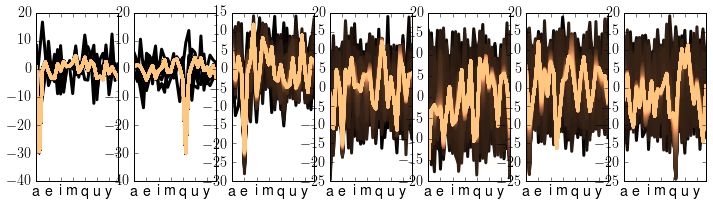

In [309]:
figure(figsize=(12,3))
cols = get_cmap('copper', n_steps)
alph = np.array(list(alphabet))
xv = arange(0, len(alph), 4)

lv = alph[xv]

for i in range(n_steps):
    ax=subplot(171)
    plot(l1_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    ax=subplot(172)
    plot(l2_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)

    ax=subplot(173)
    plot(l3_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    ax=subplot(174)
    plot(l4_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)

    ax=subplot(175)
    plot(l5_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    ax=subplot(176)
    plot(l6_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)

    ax=subplot(177)
    plot(l7_coef_hist[i,:], lw=3, c=cols(i))
    ax.set_xticks(xv)
    ax.set_xticklabels(lv)
    
    
    
l1 = alph[np.argmax(np.abs(l1_coef_hist[-1,:]))]
l2 = alph[np.argmax(np.abs(l2_coef_hist[-1,:]))]
l3 = alph[np.argmax(np.abs(l3_coef_hist[-1,:]))]
l4 = alph[np.argmax(np.abs(l4_coef_hist[-1,:]))]
l5 = alph[np.argmax(np.abs(l5_coef_hist[-1,:]))]
l6 = alph[np.argmax(np.abs(l6_coef_hist[-1,:]))]
l7 = alph[np.argmax(np.abs(l7_coef_hist[-1,:]))]

result = l1+l2+l3+l4+l5+l6+l7
print result

subplot(174)
#title(result)
#tag ='test'

#fname = ('pcic_resonance-' + str(mxidx) + '-N='  + str(N) 
#         + '-' + tag + '-n' + time.strftime('%y%m%d'))

#print fname

#savefig(fname + '.eps', format='eps', transparent=True)
#savefig(fname + '.png', format='png', transparent=True)


In [4]:
# first tried correlation matrix of X, X
def online_regression(Past, Present, reg=1):
    corr = np.linalg.inv(np.outer(Present, Present) + reg*np.eye(N))
    return corr * np.outer(Present, Past)

# try correlation matrix of W, W instead?
def online_regression_covW(W, Past, Present, reg=1):
    corr = np.linalg.inv(W.dot(W.T) + reg*np.eye(N))
    return corr * np.outer(Present, Past)

def online_regression_covWX(W, Past, Present, reg=1):
    pred = Present.dot(W)
    corr = np.linalg.inv(np.outer(pred, Present) + reg*np.eye(N))
    return corr * np.outer(Present, Past)

{'#': array([-1, -1,  1,  1,  1,  1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1,  1,
         1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1,  1,
         1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1, -1,
         1,  1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1, -1,  1,
         1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,
        -1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
        -1,  1,  1,  1, -1,  1,  1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1,
         1,  1, -1,  1,  1,  1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1,  1,
        -1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1,  1, -1, -1,
        -1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1,  1,  1, -1,  1,
         1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1, -1,
         1, -1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1, -1, -1, -1,  1, -1,
        -1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1,
       

figures/online_regression-regularized_trigam-N=1000-W=1889-reg=1-170429


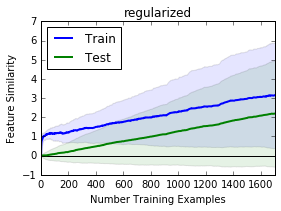

In [17]:
W = np.zeros((N,N))

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])
reg = 1

y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N
    
    W += online_regression(trainpast2[k], trainpres1[k])
    
graph(x,y1,y2,y1std,y2std,title='regularized',legend='upper left')

fname =  ('figures/online_regression-regularized_trigam-N=' + str(N)
          + '-W=' + str(len(trainpres1)) + "-reg=" + str(reg)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [ ]:
graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title="regularized",legend="upper left") 

fname =  ('figures/online_regression-separate-regularized_trigam-N=' + str(N)
          + '-W=' + str(len(trainpres1)) + "-reg=" + str(reg)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/online_regressionW-regularized_trigam-N=1000-W=1700-reg=1-170503


/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: Mean of empty slice.
/Users/quinntran/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


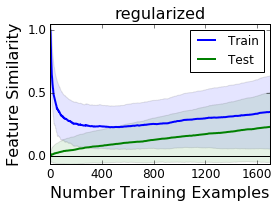

In [5]:
W = online_regression(trainpast2[0], trainpres1[0])

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])
reg = 1

y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)

    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N
    
        
    W += online_regression_covW(W, trainpast2[k], trainpres1[k])

graph(x,y1,y2,y1std,y2std,title='regularized',legend='upper right')

fname =  ('figures/online_regressionW-regularized_trigam-N=' + str(N)
          + '-W=' + str(len(trainpres1)) + "-reg=" + str(reg)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/online_regressionW-regularized_trigam-N=1000-W=1889-reg=1-170429


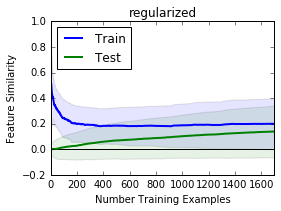

In [16]:
graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title="regularized",legend="upper left")  

fname =  ('figures/online_regressionW-separate-regularized_trigam-N=' + str(N)
          + '-W=' + str(len(trainpres1)) + "-reg=" + str(reg)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/online_regressionWX-regularized_trigam_regression-N=1000-W=1889-reg=1-170429


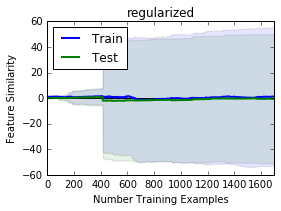

In [21]:
W = online_regression(trainpast2[0], trainpres1[0])

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])
reg = 1

y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N
    
    
    W += online_regression_covWX(W, trainpast2[k], trainpres1[k])
    
graph(x,y1,y2,y1std,y2std,title='regularized',legend='upper left')

fname =  ('figures/online_regressionWX-regularized_trigam_regression-N=' + str(N)
          + '-W=' + str(len(trainpres1)) + "-reg=" + str(reg)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [ ]:
graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title="regularized",legend="upper left")  

fname =  ('figures/online_regressionWX-separate-regularized_trigam_regression-N=' + str(N)
          + '-W=' + str(len(trainpres1)) + "-reg=" + str(reg)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [23]:
alpha=1e-3
kernels = ["linear", "laplacian", "polynomial", "sigmoid"]
clf = KernelRidge(alpha=alpha,kernel="polynomial")
# KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='linear', kernel_params=None)

for ad in range(1):
    alpha += ad*1e-3
    x = np.arange(1, trainpres1.shape[0], 50)
    y1 = np.zeros(x.shape[0])
    y2 = np.zeros(x.shape[0])
    y1std = np.zeros(x.shape[0])
    y2std = np.zeros(x.shape[0])
    
    y1irregular = np.zeros(x.shape[0])
    y2irregular = np.zeros(x.shape[0])

    sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]


    for i in range(x.shape[0]):
        k = x[i]
        
        clf.fit(trainpres1[:k], trainpast2[:k]) 
        
        train_pred = clf.predict(trainpres1[:k])
        test_pred = clf.predict(testpres1)

        sim1 = sim(train_pred, trainpast2[:k])
        sim2 = sim(test_pred, testpast2)
        
        sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

        irregularsim1 = sim1[sim1indices]
        irregularsim2 = sim2[sim2indices]

        y1[i] = sim1.mean()/N
        y1std[i] = np.nanstd(sim1, axis=0)/N
        y2[i] = sim2.mean()/N
        y2std[i] = np.nanstd(sim2, axis=0)/N

        y1irregular[i] = irregularsim1.mean()/N
        y2irregular[i] = irregularsim2.mean()/N
    

    graph(x,y1,y2,y1std,y2std,title='ridge_regression_alpha='+str(alpha), legend='lower right')    

    fname =  ('figures/online-regression-kernel_ridge_regression_trigam-N=' + str(N) 
              + '-W=' + str(len(trainpres1))
              + '-alpha=' + str(alpha)
              + '-' + time.strftime('%y%m%d'))
    print fname

    plt.savefig(fname + '.png', transparent=True)
    plt.savefig(fname + '.eps', transparent=True)
    
    graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title='ridge_regression_alpha='+str(alpha),legend='lower right')     

    fname =  ('figures/online-regression-seperate-kernel_ridge_regression_trigam-N=' + str(N) 
              + '-W=' + str(len(trainpres1))
              + '-alpha=' + str(alpha)
              + '-' + time.strftime('%y%m%d'))
    print fname

    plt.savefig(fname + '.png', transparent=True)
    plt.savefig(fname + '.eps', transparent=True)

TypeError: graph() got multiple values for keyword argument 'title'

In [7]:
# alternative idea: add leastsquares soln by getting singular values from the soln. bc the directions will be generalized?
# online svd where the singular values is the regularization. u, v are the binding
# seems like another iteration of the paper then. another time....
# def pcaw_train(past, present, num_pc=20):
#     pp_pair = np.multiply(past, present)
#     tst = time.time()
#     pp_u, pp_s, pp_v = np.linalg.svd(pp_pair)
#     #print 'Elapsed: ', time.time() - tst
    
#     cidx = min(num_pc, pp_u.shape[1])
#     return np.dot(pp_u[:, :cidx], pp_v[:cidx, :]).sum(axis=0)

# def regression_train(past, present):
#     w = np.linalg.lstsq(present, past)[0]
#     return w



Stochastic gradient descent


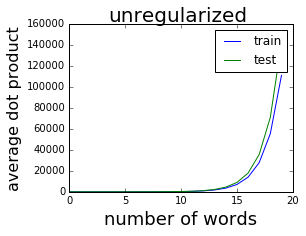

figures/unregularized_trigam_regression-170409


In [43]:
p = N
p_var = 0.015
alpha=1e-3
reg=0.1

x = np.arange(1, trainpres1.shape[0], 1)
x = np.arange(0, num_iter, 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

print("Stochastic gradient descent")
W = np.zeros((N,N))
for i in range(x.shape[0]):
    k = x[i]
    W = train_sgd(trainpres1, trainpast2, W, i, alpha, reg)
    train_pred = predict(W, trainpres1)
    test_pred = predict(W, testpres1)
    
    
    y1[i] = sim(train_pred, trainpast2).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
    
graph(x,y1,y2,title='unregularized',legend='upper right')

fname =  ('figures/unregularized_trigam_regression') + '-' + time.strftime('%y%m%d')
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

Batch gradient descent


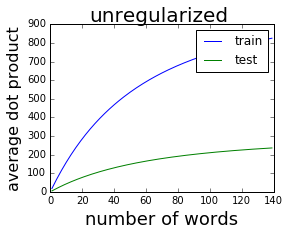

figures/unregularized_trigam_regression-170409


In [47]:
p = N
p_var = 0.015
alpha=1e-3
reg=0.1

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

print("Batch gradient descent")
W = np.zeros((N,N))
for i in range(x.shape[0]):
    k = x[i]
    W = train_gd(trainpres1, trainpast2, W, alpha, reg)
    train_pred = predict(W, trainpres1)
    test_pred = predict(W, testpres1)
    
    
    y1[i] = sim(train_pred, trainpast2).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
    
graph(x,y1,y2,title='unregularized',legend='upper right')

fname =  ('figures/unregularized_trigam_regression') + '-' + time.strftime('%y%m%d')
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)